## The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, I was asked to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Let's start with importing the libraries!

In [1]:
#Data Analysis
import pandas as pd
import numpy as np
import random as rnd

#Plotting and Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

Next, I will import the data to be used.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combine = [train,test]

Let's see how our data looks like!

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


What is the distribution of categorical features? It might be helpful in further understanding our dataset.

In [5]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Baclini, Miss. Helene Barbara",male,347082,B96 B98,S
freq,1,577,7,4,644


Here's a list of things I should do after seeing the data:
1. Correlation - How does each feature correlate with survival?
2. Completion - May want to complete Age and Embarked as they may correlate with survival
3. Correction - May want to drop name, id, cabin, feature, ticket, fare, and embarked as they are either incomplete, or most likeley show no correlation to survival
4. Creation - May want to create family column based on Parch and SibSp, and create new column for age banks as it will turn a continuiys numerical feature into an ordinal categorical feature

Some assumptions:
1. Women may have been more likely to survive
2. Higher ticket class (Pclass = 1) may have been more likely to survive

So let's check these assumptions first.

In [6]:
#Assumption 1
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [7]:
#Assumption 2
train[['Pclass','Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


We can generally work on these assumptions, as females had a survival rate of 74% (males 19%), and a higher Pclass represented a higher chance of survival.

## Analyze from visualization
Let's first see what age group was most likely to survive. Let's use seaborn's Facetgrid to visualize multiple graphs at the same time.

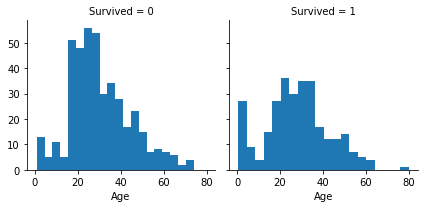

In [8]:
g = sns.FacetGrid(train, col = 'Survived')
g.map(plt.hist,'Age', bins =20)


This shows that age does in fact correlate with survivability, with most people aged from 20-30 not surviving. We will add this to our model training.

What about Pclass? Let's check that out as well!

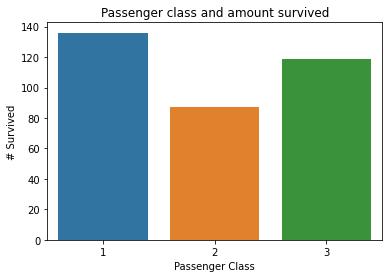

In [9]:
survived = [train[(train.Pclass == 1) & (train.Survived ==1)].Survived.count(),
    train[(train.Pclass == 2) & (train.Survived ==1)].Survived.count(),
    train[(train.Pclass == 3) & (train.Survived ==1)].Survived.count()]

pclass_survived = pd.DataFrame({'Passenger Class':['1','2','3'],'# Survived': survived})

plt.title('Passenger class and amount survived')
barplot = sns.barplot(x = 'Passenger Class', y = "# Survived", data = pclass_survived)


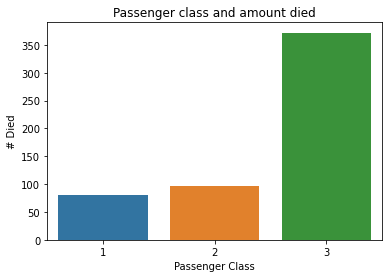

In [10]:
died = [train[(train.Pclass == 1) & (train.Survived ==0)].Survived.count(),
    train[(train.Pclass == 2) & (train.Survived ==0)].Survived.count(),
    train[(train.Pclass == 3) & (train.Survived ==0)].Survived.count()]

pclass_died = pd.DataFrame({'Passenger Class':['1','2','3'],'# Died': died})

plt.title('Passenger class and amount died')
barplot = sns.barplot(x = 'Passenger Class', y = "# Died", data = pclass_died)


These two bar graphs overwhelmingly show that the lower the class (1 being the highest), the less likely you are to survive, even if there were more people in class 3. We can also check this by looking at the chances of surviving per class.

In [11]:
pclass_percentage = [round(100*survived[0]/(survived[0]+died[0]),2),
                    round(100*survived[1]/(survived[1]+died[1]),2),
                    round(100*survived[2]/(survived[2]+died[2]),2)]
for i in range(3):
    print('Passenger class', i+1, 'Survival Rate: ', pclass_percentage[i])

Passenger class 1 Survival Rate:  62.96
Passenger class 2 Survival Rate:  47.28
Passenger class 3 Survival Rate:  24.24


As a result, we will add passenger class to model training.

## Data Wrangling
Now that we have our assumptions, and what we want to add to model training, let's make the data useable for model training.
First, let's drop Ticket, Cabin, Fare and Embarked since we aren't too concerned about them. 

In [12]:
train = train.drop(['Ticket', 'Cabin','Embarked', 'Fare', 'Name','SibSp', 'Parch'], axis = 1)
test = test.drop(['Ticket', 'Cabin','Embarked', 'Fare', 'Name','SibSp', 'Parch'], axis = 1)
combine = [train,test]

In [13]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age
0,1,0,3,male,22.0
1,2,1,1,female,38.0
2,3,1,3,female,26.0
3,4,1,1,female,35.0
4,5,0,3,male,35.0


Let's convert Sex to a numerical value, where female = 1, male = 0.

In [14]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [15]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age
0,1,0,3,0,22.0
1,2,1,1,1,38.0
2,3,1,3,1,26.0
3,4,1,1,1,35.0
4,5,0,3,0,35.0


Next, let's fill in any missing values from the Age column. Let's guess missing values using median values for age across pclass and gender.

In [16]:
#Finding Median Values

guess_ages = np.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train.head()

,PassengerId,Survived,Pclass,Sex,Age
0,1,0,3,0,22
1,2,1,1,1,38
2,3,1,3,1,26
3,4,1,1,1,35
4,5,0,3,0,35


Let's create age bands to classify each passenger.

In [17]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train.head()

,PassengerId,Survived,Pclass,Sex,Age
0,1,0,3,0,1
1,2,1,1,1,2
2,3,1,3,1,1
3,4,1,1,1,2
4,5,0,3,0,2


## Modelling
Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). So let's try the following models
1. Logistic Regression
2. KNN or k-Nearest Neighbors
3. Support Vector Machines
4. Naive Bayes classifier
5. Decision Tree
6. Random Forest


In [18]:
X_train = train.drop(["Survived",'PassengerId'], axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()
X_train
X_train.shape, Y_train.shape, X_test.shape

((891, 3), (891,), (418, 3))

In [33]:
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

78.68

In [21]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Pclass,2.524989
2,Sex,-0.030330
0,Survived,-0.969942
3,Age,NaN


In [22]:
#Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

78.79

In [23]:
#K-Nearest Neighbour
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

77.1

In [24]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

75.53

In [25]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

80.81

In [26]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

80.81

Let's check out all of our models and predictions!

In [27]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes','Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,80.81
5,Decision Tree,80.81
0,Support Vector Machines,78.79
2,Logistic Regression,78.68
1,KNN,77.10
4,Naive Bayes,75.53


Finally let's create the submission file.

In [28]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)

## Conclusion
And that marks the end of the Titanic Challenge! This was an excited and challenging task that I learned a lot from, especially in cleaning, machine learning, and developping an appropriate mindset for competitions like this one. 

Thank you for taking the time to read all of this! This notebook has develop my skills in data science, and I can't wait to see what's next :) Feel free to reach out to me if you have any questions/comments/suggestions on how I can improve for the future.

Contact info:

LinkedIn: https://www.linkedin.com/in/quinn-ha/

Email: hab8@mcmaster.ca